In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# Import and establish Base for which classes will be constructed 
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

In [25]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [26]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [28]:
# Create our session (link) from Python to the DB
Session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.
Latest_date = Session.execute("SELECT MAX(date) FROM Measurement").fetchall()

Latest_date = Session.query(func.max(Measurement.date)).all()
#print(Latest_date)
End_Date = Latest_date[0][0]
print(End_Date)

2017-08-23


2016-08-23
Date range is starting from 2016-08-23 and ending at 2017-08-23
<class 'pandas.core.frame.DataFrame'>
Index: 2230 entries, 2016-08-23 to 2017-08-23
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Precipitation Score  2021 non-null   float64
dtypes: float64(1)
memory usage: 34.8+ KB
None
            Precipitation Score
Date                           
2017-08-22                 0.00
2017-08-23                 0.45
2017-08-23                 0.08
2017-08-23                 0.00
2017-08-23                 0.00


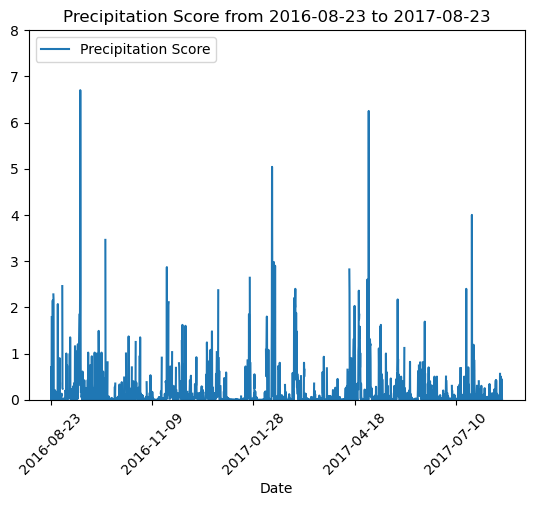

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
Struct = dt.date.today()
End_Date_dateformat = Struct.replace(year=int(End_Date[:4]),month=int(End_Date[5:7]),day=int(End_Date[8:]))
Last_date_year = End_Date_dateformat - dt.timedelta(days=365)    
Start_Date = Last_date_year.strftime("%Y-%m-%d")
print(Start_Date)
# Calculate the date one year from the last date in data set.
print("Date range is starting from {} and ending at {}".format(Start_Date,End_Date))

# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame. Explicitly set the column names
PRCP_data = Session.query(Measurement.date,Measurement.prcp)\
                          .filter(Measurement.date <= End_Date)\
                          .filter(Measurement.date >= Start_Date)\
                          .order_by(Measurement.date.desc()).all()

# Sort the dataframe by date
PRCP_data_DF = pd.DataFrame(PRCP_data).rename(columns={"date":"Date","prcp":"Precipitation Score"})
# PRCP_data_DF["Date"] = pd.to_datetime(PRCP_data_DF["Date"],format="%Y-%m-%d")
PRCP_data_DF.sort_values("Date",inplace=True)
PRCP_data_DF.set_index("Date",inplace=True)
print(PRCP_data_DF.info())
print(PRCP_data_DF.tail())

# Use Pandas Plotting with Matplotlib to plot the data
PRCP_data_DF.plot(ylim=(0,8),title=f'Precipitation Score from {Start_Date} to {End_Date}',\
                  label="Precipitation",rot=45)
plt.legend(loc="upper left")
plt.savefig("Resources/1_Precipitation_Analysis.jpg")
plt.show()

In [41]:
# Use Pandas to calculate the summary statistics for the precipitation data
PRCP_data_DF.describe() 


,Precipitation Score
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
Total_stations = Session.query(Station).count()
print('Total number of stations is: {}'.format(Total_stations))

Total number of stations is: 9


In [43]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
Most_Active_Station = Session.query(Measurement.station,func.count(Measurement.station))\
                          .group_by(Measurement.station)\
                          .order_by(func.count(Measurement.station).desc()).all()
Most_Active_Station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [44]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp = Session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                          .filter(Measurement.station == 'USC00519281').all()
temp
    

[(54.0, 85.0, 71.66378066378067)]

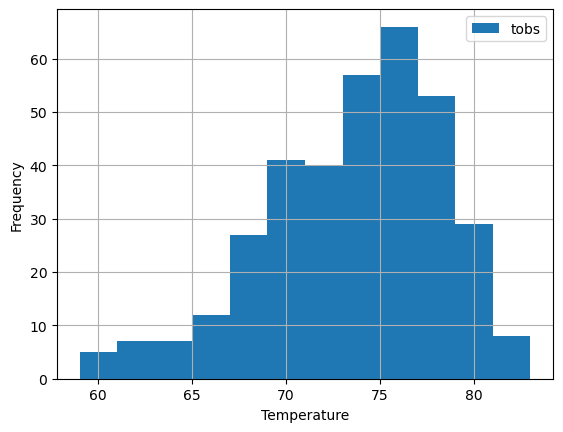

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = Session.query(Measurement.tobs)\
                          .filter(Measurement.date <= End_Date)\
                          .filter(Measurement.date >= Start_Date)\
                          .filter(Measurement.station == 'USC00519281').all()
temp_df = pd.DataFrame(temp_data, columns = ["tobs"])

temp_df.plot(kind ="hist", bins = 12)
plt.grid()
plt.xlabel("Temperature")
plt.show()

# Close Session

In [53]:
# Close Session
Session.close()